## Neural Network:
Neural Networks (NNs) are computing systems vaguely inspired by the biological neural networks that constitute animal brains. NN is based on a collection of connected units or nodes called **artificial neurons**, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron that receives a signal then processes it and can signal neurons connected to it. The "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs. The connections are called **edges**. Neurons and edges typically have a **weight** that adjusts as learning proceeds. Neurons are aggregated into layers. Different layers may perform different transformations on their inputs. Signals travel from the first layer (the input layer), to the last layer (the output layer), possibly after traversing the layers multiple times.
 


## Numta Database: 
This is a large dataset (85,000+) of Bengali digits which can be used by researchers for benchmarking their algorithm. One of the key topics of NLP is optical character recognition (OCR). To build an OCR in Bengali language, digit classification provides a convenient starting point. For this purpose, this database was built to aid researchers and students alike.


For the given experiment we are to perform the following: Apply **Neural Network / Deep Neural Network** for the **NumtaDB** dataset and build a multiclass classification model that can recognize `[0-9]` Bengali handwritten digits with different hyperparameter settings.


For this task, we will use the NumtaDB dataset for digit recognition purposes. Hence we will use the training datasets a, c and d for this goal.

In the given experiment, we are using the following fixed hyper-parameters:

- **Input dimension: 784**
  - Size of image: $28 \times 28 = 784$

- **Output dimension: 10**
  - 0, 1, 2, 3, 4, 5, 6, 7, 8, 9

The images in NumtaDB are stored as $28 \times 28$ images. The images are labeled(with the value of the digit in the image) and catalogued in separate csv files, which is what we will use to access the images for the experiment.

<div align="center">
<img src="https://drive.google.com/uc?id=1LvkNwV1My2RniR_JsbasBET1fa97eMQu" width="500">
</div>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install kaggle
#upload kaggle.json
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ashnanawarahmed","key":"0b75ee43fb4820370e77d4e2dc4cce51"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

#changing permission
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d BengaliAI/numta

from zipfile import ZipFile
file_name='numta.zip'
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('done')

100% 1.91G/1.91G [00:17<00:00, 37.8MB/s]
100% 1.91G/1.91G [00:17<00:00, 116MB/s] 
done


In [ ]:
import os
from os import path
import shutil
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import models
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime

import torchvision.transforms as transforms
import torchvision.datasets as dsets

In [ ]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name())

Tesla T4


In [ ]:
#load_model = True
load_model = False
if load_model is True:
    model.load_state_dict(torch.load('/content/gdrive/My Drive/Colab Notebooks/NumtaDB/'+ 'bangla_digit_recognizer_logistic.pkl'))
    print('Trained Model Loaded')

In [ ]:
#FUNCTION FOR PRINTING CURRENT TIME
def curr_time():
  now = datetime.now()

  current_time = now.strftime("%H:%M:%S") 
  print("Current Time =", current_time)

In [ ]:
PATH = '/content/'
os.listdir(PATH)
def showRawTrainingSamples(csv_filename):
  df = pd.read_csv(PATH + csv_filename)
  print(csv_filename)
  print(df.columns)
  return df

a_csv = showRawTrainingSamples('training-a.csv')
c_csv = showRawTrainingSamples('training-c.csv')
d_csv = showRawTrainingSamples('training-d.csv')
def dropColumns(csv_file):
  csv_file = csv_file[['filename', 'digit']]
  print(csv_file)
  print(csv_file.iloc[:5, :])   #First 5 Rows of the CSV File
  print("=============================")
  return csv_file

a_csv = dropColumns(a_csv)
c_csv = dropColumns(c_csv)
d_csv = dropColumns(d_csv)


total_csv = [a_csv, c_csv, d_csv]
merged_csv = pd.concat(total_csv)
print(len(merged_csv))

TRAIN_PATH = 'train'
os.mkdir(TRAIN_PATH)

def processImages(folder_name):
  src = PATH + folder_name + '/'
  dir_folders = os.listdir(src)
  for dir_name in dir_folders:
    file_name = os.path.join(src, dir_name)
    if os.path.isfile(file_name):
      shutil.copy(file_name, TRAIN_PATH) 

processImages('training-a')
print('A Done')
processImages('training-c')
print('C Done')
processImages('training-d')
print('D Done')



training-a.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-c.csv
Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')
training-d.csv
Index(['original filename', 'scanid', 'digit', 'num', 'database name original',
       'database name', 'filename'],
      dtype='object')
         filename  digit
0      a00000.png      5
1      a00001.png      3
2      a00002.png      1
3      a00003.png      7
4      a00004.png      0
...           ...    ...
19697  a19697.png      4
19698  a19698.png      3
19699  a19699.png      8
19700  a19700.png      3
19701  a19701.png      8

[19702 rows x 2 columns]
     filename  digit
0  a00000.png      5
1  a00001.png      3
2  a00002.png      1
3  a00003.png      7
4  a00004.png      0
         filename  digit
0      c00000.png      6
1      c

In [ ]:
class Dataset(Dataset):
    def __init__(self, df, root, transform=None):
        self.data = df
        self.root = root
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        item = self.data.iloc[index]
        
        path = self.root + "/" + item[0]
        image = Image.open(path).convert('L') #converting images to grayscale
        label = item[1]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

# SETTING 1:
## Hyperparameters:
**Iteration: 5k**

**Batch Size: 200**

**Learning Rate: 0.001**

**Number of Hidden Layers: 3 (SELU->SELU->SELU)**

**Dimension of Hidden Layers: 100**

**Optimizer: Adam**


Training Samples:  54908
Train dataloader:248
Test dataloader:28
Current Time = 05:17:53
Batch size: 200 ; Number of iterations: 5000 ; Learning rate: 0.001 ; Total training data size: 54908 ; Epoch size: 18
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 1.9564881324768066. Accuracy: 33.970856102003644
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 1.5914802551269531. Accuracy: 50.60109289617486
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 1.1734247207641602. Accuracy: 54.66302367941712
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 1.220481276512146. Accuracy: 61.12932604735884
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 0.9798794388771057. Accuracy: 64.2440801457195
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 0.8752567768096924. Accuracy: 67.50455373406193
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 0.8227186799049377. Accuracy: 68.85245901639344
Epoch: 16
Epoch: 17
Iter

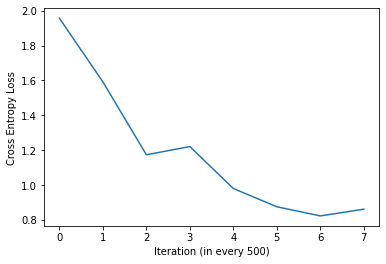

In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 5000
input_dim = 28*28 # num_features = 784
num_hidden = 100 # num of hidden nodes
output_dim = 10

learning_rate = 0.001  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Training Samples: ",len(train_data))



# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))


class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.selu_1 = nn.SELU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.selu_2 = nn.SELU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.selu_3 = nn.SELU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.selu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.selu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.selu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


'''
TRAIN THE MODEL
'''
iter = 0
iteration_loss = []
curr_time()
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()

#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# SETTING 2:
## Hyperparameters:
**Iteration: 10k**

**Batch Size: 200**

**Learning Rate: 0.001**

**Number of Hidden Layers: 3 (SELU->SELU->SELU)**

**Dimension of Hidden Layers: 100**

**Optimizer: Adam**


Training Samples:  54908
Train dataloader:248
Test dataloader:28
Current Time = 07:25:11
Batch size: 200 ; Number of iterations: 10000 ; Learning rate: 0.001 ; Total training data size: 54908 ; Epoch size: 36
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 2.0915651321411133. Accuracy: 35.51912568306011
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 1.8182162046432495. Accuracy: 47.7959927140255
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 1.3999807834625244. Accuracy: 50.91074681238616
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 1.4014989137649536. Accuracy: 59.326047358834245
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 1.2082432508468628. Accuracy: 58.87067395264116
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 1.040671944618225. Accuracy: 63.57012750455373
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 0.9737796783447266. Accuracy: 67.59562841530055
Epoch: 16
Epoch: 17
Ite

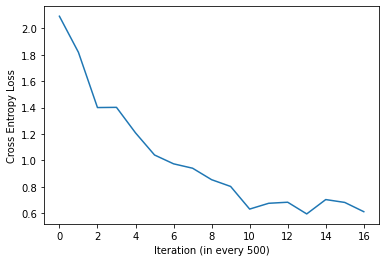

In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 10000
input_dim = 28*28 # num_features = 784
num_hidden = 100 # num of hidden nodes
output_dim = 10

learning_rate = 0.001  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Training Samples: ",len(train_data))



# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))


class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.selu_1 = nn.SELU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.selu_2 = nn.SELU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.selu_3 = nn.SELU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.selu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.selu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.selu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


'''
TRAIN THE MODEL
'''
iter = 0
iteration_loss = []
curr_time()
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()

#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# SETTING 3:
## Hyperparameters:
**Iteration: 15k**

**Batch Size: 200**

**Learning Rate: 0.001**

**Number of Hidden Layers: 3 (SELU->SELU->SELU)**

**Dimension of Hidden Layers: 100**

**Optimizer: Adam**


Training Samples:  54908
Train dataloader:248
Test dataloader:28
Current Time = 09:38:17
Batch size: 200 ; Number of iterations: 15000 ; Learning rate: 0.001 ; Total training data size: 54908 ; Epoch size: 54
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 1.8493189811706543. Accuracy: 36.63023679417122
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 1.7507061958312988. Accuracy: 40.41894353369763
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 1.2291587591171265. Accuracy: 52.82331511839708
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 1.0827468633651733. Accuracy: 58.5063752276867
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 1.167141079902649. Accuracy: 65.28233151183971
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 1.1568995714187622. Accuracy: 66.04735883424408
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 0.9445348978042603. Accuracy: 68.5063752276867
Epoch: 16
Epoch: 17
Itera

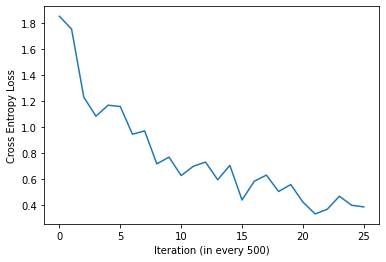

In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 15000
input_dim = 28*28 # num_features = 784
num_hidden = 100 # num of hidden nodes
output_dim = 10

learning_rate = 0.001  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Training Samples: ",len(train_data))



# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))


class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.selu_1 = nn.SELU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.selu_2 = nn.SELU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.selu_3 = nn.SELU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.selu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.selu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.selu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


'''
TRAIN THE MODEL
'''
iter = 0
iteration_loss = []
curr_time()
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()

#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

# SETTING 4:
## Hyperparameters:
**Iteration: 20k**

**Batch Size: 200**

**Learning Rate: 0.001**

**Number of Hidden Layers: 3 (SELU->SELU->SELU)**

**Dimension of Hidden Layers: 100**

**Optimizer: Adam**


Training Samples:  54908
Train dataloader:248
Test dataloader:28
Current Time = 08:08:39
Batch size: 200 ; Number of iterations: 20000 ; Learning rate: 0.001 ; Total training data size: 54908 ; Epoch size: 72
-----------------------------------------------------------------------------------------------------------------------------------
Epoch: 1
Epoch: 2
Epoch: 3
Iteration: 500. Loss: 1.8977938890457153. Accuracy: 34.3351548269581
Epoch: 4
Epoch: 5
Iteration: 1000. Loss: 1.7175081968307495. Accuracy: 45.39162112932605
Epoch: 6
Epoch: 7
Iteration: 1500. Loss: 1.4935857057571411. Accuracy: 54.00728597449909
Epoch: 8
Epoch: 9
Iteration: 2000. Loss: 1.2475301027297974. Accuracy: 56.32058287795993
Epoch: 10
Epoch: 11
Iteration: 2500. Loss: 1.0792323350906372. Accuracy: 60.85610200364299
Epoch: 12
Epoch: 13
Iteration: 3000. Loss: 0.9700865149497986. Accuracy: 66.28415300546447
Epoch: 14
Epoch: 15
Iteration: 3500. Loss: 0.9930979013442993. Accuracy: 67.85063752276866
Epoch: 16
Epoch: 17
Ite

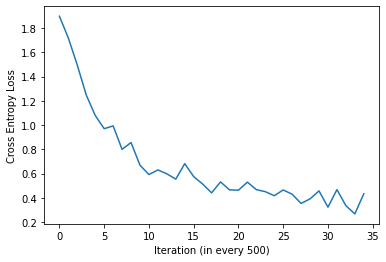

In [ ]:
# Hyperparameters

batch_size = 200
num_iters = 20000
input_dim = 28*28 # num_features = 784
num_hidden = 100 # num of hidden nodes
output_dim = 10

learning_rate = 0.001  # More power so we can learn faster! previously it was 0.001

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

mean = [0.5,]
std = [0.5, ]

train_transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
        transforms.Resize(28),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

train_data  = Dataset(merged_csv, TRAIN_PATH, train_transform)
test_data = Dataset(merged_csv, TRAIN_PATH, test_transform)

print("Training Samples: ",len(train_data))



# split data 10% for testing
test_size = 0.1

num_epochs = num_iters / (len(train_data) / batch_size)
num_epochs = int(num_epochs)


# obtain training indices that will be used for validation
num_train = len(train_data)

# mix data
# index of num of train
indices = list(range(num_train))
# random the index
np.random.shuffle(indices)
split = int(np.floor(test_size * num_train))
# divied into two part
train_idx, test_idx = indices[split:], indices[:split]

# define the sampler
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

# prepare loaders
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size,
    sampler=train_sampler)

test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size,
    sampler=test_sampler)

print("Train dataloader:{}".format(len(train_loader)))
print("Test dataloader:{}".format(len(test_loader)))


class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()
        ### 1st hidden layer: 784 --> 100
        self.linear_1 = nn.Linear(input_size, num_hidden)
        ### Non-linearity in 1st hidden layer
        self.selu_1 = nn.SELU()

        ### 2nd hidden layer: 100 --> 100
        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 2nd hidden layer
        self.selu_2 = nn.SELU()

        ### 3rd hidden layer: 100 --> 100
        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        ### Non-linearity in 3rd hidden layer
        self.selu_3 = nn.SELU()

        ### Output layer: 100 --> 10
        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        ### 1st hidden layer
        out  = self.linear_1(x)
        ### Non-linearity in 1st hidden layer
        out = self.selu_1(out)
        
        ### 2nd hidden layer
        out  = self.linear_2(out)
        ### Non-linearity in 2nd hidden layer
        out = self.selu_2(out)

        ### 3rd hidden layer
        out  = self.linear_3(out)
        ### Non-linearity in 3rd hidden layer
        out = self.selu_3(out)
        
        # Linear layer (output)
        probas  = self.linear_out(out)
        return probas


# INSTANTIATE MODEL CLASS

model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim,
                               num_hidden = num_hidden)
# To enable GPU
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


'''
TRAIN THE MODEL
'''
iter = 0
iteration_loss = []
curr_time()
print('Batch size:',batch_size,'; Number of iterations:',num_iters,'; Learning rate:',learning_rate,'; Total training data size:',num_train,'; Epoch size:',num_epochs)
print('-----------------------------------------------------------------------------------------------------------------------------------')
for epoch in range(num_epochs):
    print('Epoch:',epoch+1)
    for i, (images, labels) in enumerate(train_loader):
        
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1

        if iter % 500 == 0:
            # Calculate Accuracy         
            correct = 0
            total = 0
            # Iterate through test dataset
            for images, labels in test_loader:
               
                images = images.view(-1, 28*28).to(device)

                # Forward pass only to get logits/output
                outputs = model(images)

                # Get predictions from the maximum value
                _, predicted = torch.max(outputs, 1)

                # Total number of labels
                total += labels.size(0)


                # Total correct predictions
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            iteration_loss.append(loss.item())
            # Print Loss
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))
print('-----------------------Simulation ends----------------------')
curr_time()

#PLOTTING LOSS PER 500 ITERATIONS

print (iteration_loss)
plt.plot(iteration_loss)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('Iteration (in every 500)')
plt.show()

### **In this experiment we tuned the hyperparameters in such a way that the progression of accuracy can be seen in the 4 settings as follows:**
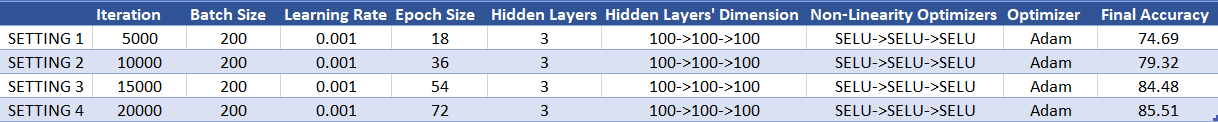

**Here we have kept the rest of the hyperparameters other than the *Iteration* the same after having experimented with them beforehand. Due to this we can see the progression of the accuracy in an objective manner. We tried 15 different settings before finally settling on the 4 we have highlighted.**

The **loss functions** can also be seen as follows:


## **Setting 1:**
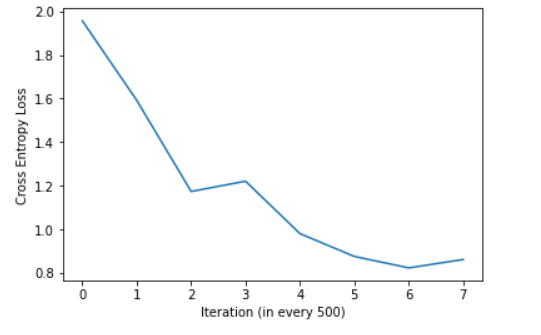

## **Setting 2:**
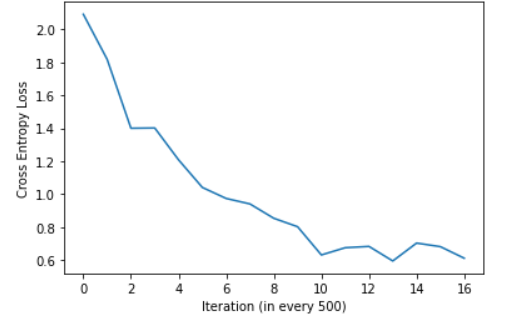

## **Setting 3:**
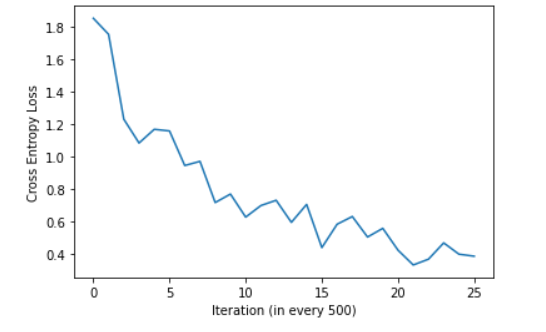

## **Setting 4:**
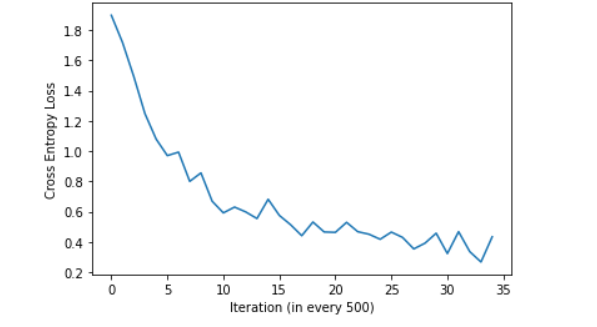

Here we can see that when the iterations were fewer, the loss function's curves were relatively smoother compared to when the iterations were increased.